#Problème n°1

La bonne transmission de signaux électromagnétiques dans l'atmosphère peut dépendre de la météo. La pluie affecte notoirement les échanges entre les antennes relais des réseaux mobiles actuels. C'est une gêne, mais aussi une opportunité: l'atténuation des ondes électromagnétiques due à la pluie peut être mesurée et utilisée comme un moyen de quantifier les précipitations.

Dans ce problème, on s'intéresse à la conversion de l'atténuation, définie comme un rapport entre puissance émise et puissance reçue et exprimée en dB, en un taux de pluie moyen le long de segments physiques dont les extrémités sont des paires d'antennes relais.

Evidemment, d'autres éléments que le pluie, plus ou moins bien connus, peuvent influencer l'atténuation. La simulation sur laquelle nous allons travailler, qui porte sur un millier de paires d'antennes virtuelles, est construite de la façon suivante:

- pour une paire d'antennes donnée, on modélise une série temporelle de taux de pluie moyen par un processus stochastique dont les paramètres dépendent entre autres de la distance qui sépare les antennes.
- pour en tirer des atténuations, on applique à cette série les transformations suivantes:
    - un filtre convolutif, censé modéliser l'impact du film d'eau se formant sur les antennes au cours d'un épisode de pluie.
    - une conversion non-linéaire, tirée d'un modèle physique, est appliquée composante à composante.
 épisode pluvieux (ce film qui s'épaissit augmente progressivement l'atténuation).
    - un bruit haute-fréquence
    - un bruit basse fréquence

La cellules suivantes permettent de récupérer les briques de code utiles, de construire un dictionnaire contenant des identifiants de paires d'antennes (clefs) et les distances les séparant (valeurs). La dernière cellule montre des exemples de séries temporelles simulées pour quelques paires.

In [10]:
# Local clone
! git clone https://github.com/albatrousse/exam_2025.git
! cp exam_2025/utils/utils_probleme1.py .

fatal: destination path 'exam_2025' already exists and is not an empty directory.


In [11]:
# Imports
from os.path import join, isdir, isfile
from os import listdir as ls
import copy
import torch
import numpy as np
import sys
from utils_probleme1 import create_dataloader

In [12]:
# Dictionnaire des "distances" (générées au hasard)
idx2distance_train = {i: 0.2 +  1.8 * torch.rand((1,)).item() for i in range(0, 1000)}
idx2distance_val = {i: 0.2 +  1.8 * torch.rand((1,)).item() for i in range(1000, 1200)}

# Paramètres de la simulation
duration = 4096  # durée de la série temporelle (unité : minutes)
batch_size = 100  # taille d'un échantillon

# Création du dataloader (il contient toutes les étapes de la simulation)
# (en une époque, chaque paire d'antennes du dictionnaire idx2distance
# a été tirée exactement une fois)
trainloader = create_dataloader(duration, idx2distance_train, batch_size)

# Génération d'un batch contenant des séries temporelles
for batch_idx, (ids, dists, rain_rates, attenuations) in enumerate(trainloader):
    break

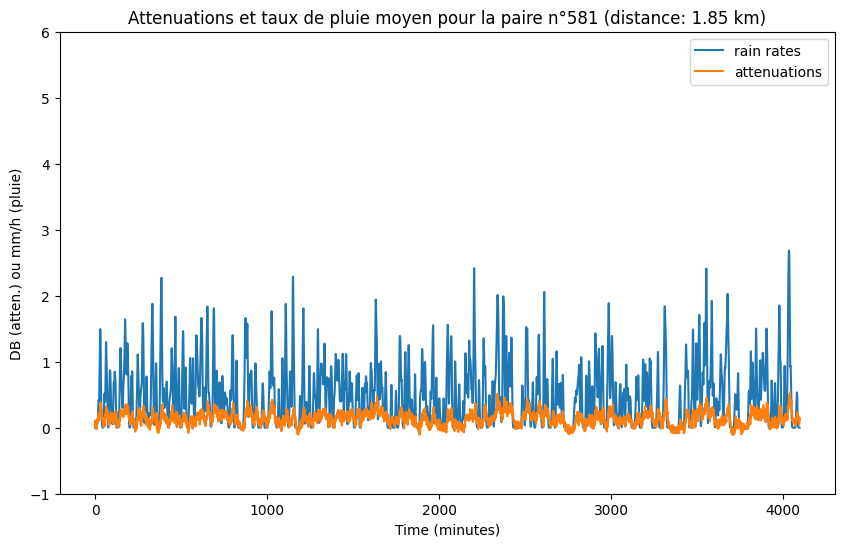

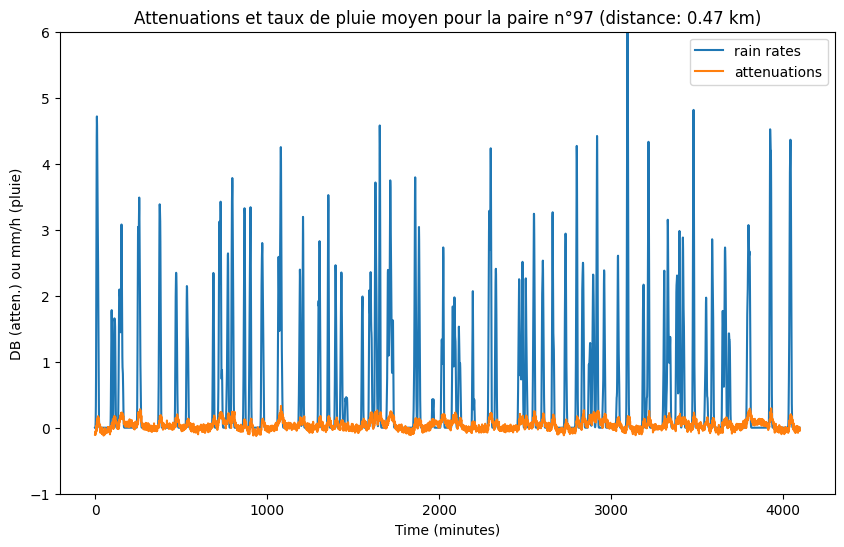

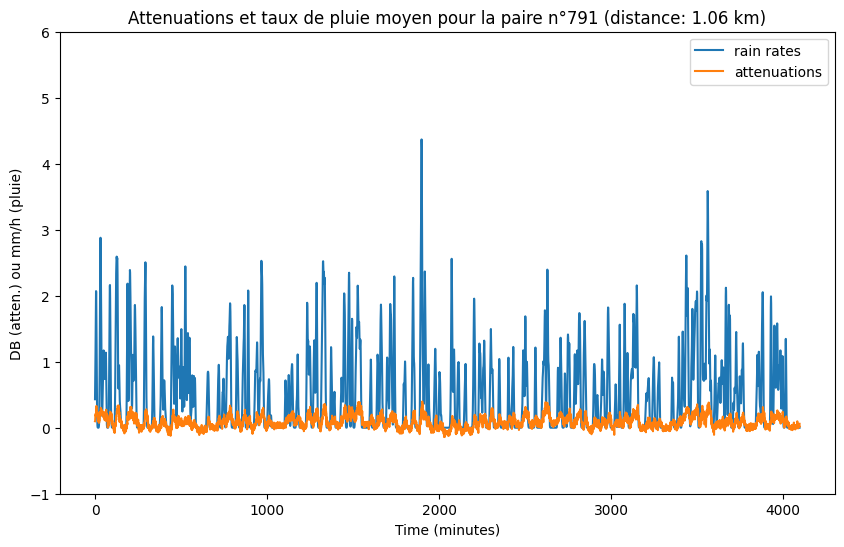

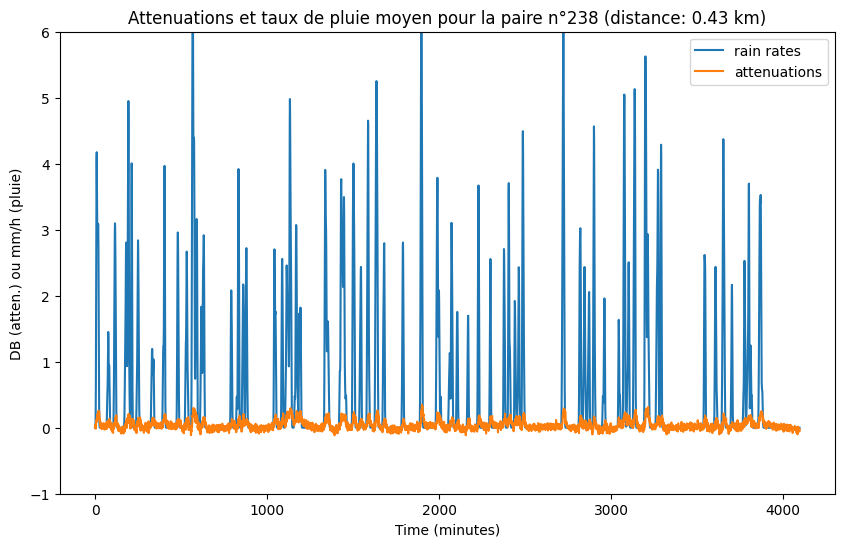

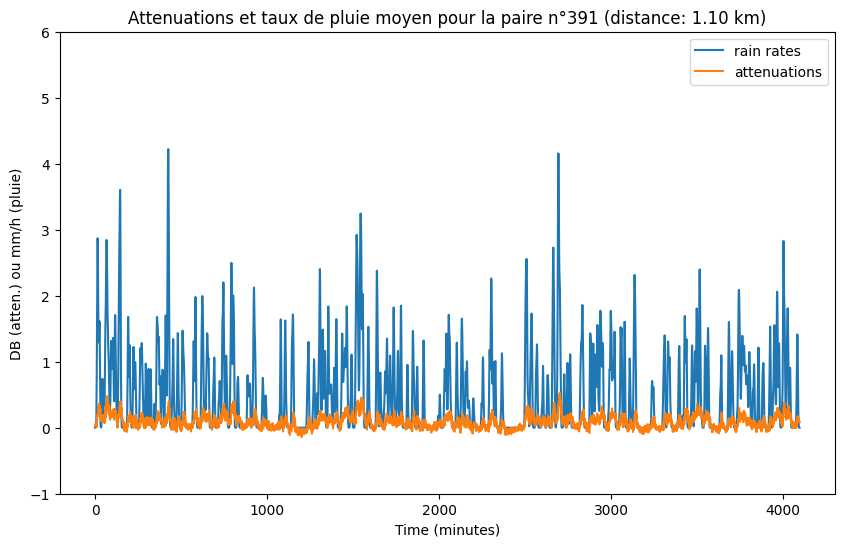

In [13]:
import matplotlib.pyplot as plt

for k in range(5):
  plt.figure(figsize=(10, 6))
  plt.plot(np.arange(duration), rain_rates[k], label='rain rates')
  plt.plot(np.arange(duration), attenuations[k], label='attenuations')
  plt.title(f"Attenuations et taux de pluie moyen pour la paire n°{ids[k].item():.0f} (distance: {dists[k].item():.2f} km)")
  plt.xlabel('Time (minutes)')
  plt.ylabel('DB (atten.) ou mm/h (pluie)')
  plt.ylim(-1,6)
  plt.legend()
  plt.show()

## Partie I : Un réseau de neurones générique

# A partir des briques de base

Dans cette partie, on entraîne un UNet1D à faire le lien entre atténuations
et taux de pluie. Les cellules suivantes contiennent les blocs du UNet1D et son montage :

In [14]:
##############################################################################################
################################     UNet 1D building blokcs    ##############################
import torch
import torch.nn as nn
import torch.nn.functional as F

class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool1d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(Up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear')
        else:
            self.up = nn.ConvTranspose1d(in_ch, in_ch, kernel_size=2, stride=2)

        self.conv = double_conv(2*in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        x2 = F.pad(x2, (diffX // 2, int(diffX / 2)))

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv1d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


################################################################################
######################################## class UNet1D ##########################

class UNet1D(nn.Module):
    def __init__(self, n_channels, n_classes, size=64):
        super(UNet1D, self).__init__()
        self.inc = inconv(n_channels, size)
        self.down1 = Down(size, 2*size)
        self.down2 = Down(2*size, 4*size)
        self.down3 = Down(4*size, 8*size)
        self.down4 = Down(8*size, 8*size)
        self.up1 = Up(8*size, 4*size)
        self.up2 = Up(4*size, 2*size)
        self.up3 = Up(2*size, size)
        self.up4 = Up(size, size)
        self.outc = outconv(size, n_classes)
        self.n_classes=n_classes

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        del x4, x5
        x = self.up2(x, x3)
        del x3
        x = self.up3(x, x2)
        del x2
        x = self.up4(x, x1)
        del x1
        x = self.outc(x)
        return   x

**Consignes:** \
1) Entraîner sur GPU un UNet 1D à restituer les taux de pluie à partir des atténuations.
- On utilisera la MSE comme fonction de coût et comme score. Dans les deux cas, prendre une marge de deux heures au début et à la fin de la série temporelle pour éviter les effets de bord.
- La descente de gradient stochastique sera pilotée par l'optimiseur ADAM (paramétrage standard) sur cinquante époques.

2) Tracer la courbe d'apprentissage de manière à montrer l'évolution:
- des performances en généralisation sur de nouvelles données issues des paires d'antennes vues à l'entraînement.
- des performances en généralisation sur des séries issues de paires d'antennes indépendantes (celles de *idx2distance_val*).


3) Visualiser les prédictions après apprentissage

In [19]:
from re import U
# Données utile
n_channels = 1
n_classes = 1
model = UNet1D(n_channels, n_classes, size=32)
size = 64       # Taille initiale des canaux dans le UNet
batch_size = 32
epochs = 20
lr = 0.001      # Taux d'apprentissage

# Instanciation du modèle, de l'optimize et du critère
model = UNet1D(n_channels, n_classes, size)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

# Déplacement du modèle sur GPU (si disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Création d'un dataloader pour la phase de validation
val_loader = create_dataloader(duration, idx2distance_val, batch_size)

# Initialisation des listes pour stocker les pertes
train_losses = []
val_losses = []

# Boucle sur les époques
for epoch in range(epochs):
    # Phase entraînement
    model.train()  # Mettre le modèle en mode entraînement
    epoch_train_loss = 0.0
    for batch_idx, (ids, dists, rain_rates, attenuations) in enumerate(trainloader):
        attenuations = attenuations.to(device)
        rain_rates = rain_rates.to(device)

        optimizer.zero_grad()

        outputs = model(attenuations.unsqueeze(1))

        loss = criterion(outputs[:, 0, 120:-120], rain_rates[:, 120:-120])

        loss.backward()

        optimizer.step()
        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(trainloader)
    train_losses.append(avg_train_loss)

    # Phase validation
    model.eval()  # Mettre le modèle en mode évaluation
    with torch.no_grad():
        epoch_val_loss = 0.0  # Initialiser la perte de validation pour l'epoch
        for batch_idx, (ids, dists, rain_rates, attenuations) in enumerate(val_loader):
            attenuations = attenuations.to(device)
            rain_rates = rain_rates.to(device)

            optimizer.zero_grad()

            outputs = model(attenuations.unsqueeze(1))

            loss = criterion(outputs[:, 0, 120:-120], rain_rates[:, 120:-120])

            optimizer.step()
            loss = criterion(outputs[:, 0, 120:-120], rain_rates[:, 120:-120])
            epoch_val_loss += loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)  # Stocker la loss de validation

    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')



Epoch [1/20], Train Loss: 0.4807, Val Loss: 0.9491
Epoch [2/20], Train Loss: 0.1933, Val Loss: 0.5412
Epoch [3/20], Train Loss: 0.1664, Val Loss: 0.3661
Epoch [4/20], Train Loss: 0.1552, Val Loss: 0.2790
Epoch [5/20], Train Loss: 0.1520, Val Loss: 0.2046
Epoch [6/20], Train Loss: 0.1485, Val Loss: 0.1382
Epoch [7/20], Train Loss: 0.1478, Val Loss: 0.1410
Epoch [8/20], Train Loss: 0.1461, Val Loss: 0.1592
Epoch [9/20], Train Loss: 0.1435, Val Loss: 0.1391
Epoch [10/20], Train Loss: 0.1423, Val Loss: 0.1215
Epoch [11/20], Train Loss: 0.1407, Val Loss: 0.1416
Epoch [12/20], Train Loss: 0.1413, Val Loss: 0.1197
Epoch [13/20], Train Loss: 0.1415, Val Loss: 0.1194
Epoch [14/20], Train Loss: 0.1392, Val Loss: 0.1344
Epoch [15/20], Train Loss: 0.1375, Val Loss: 0.1259
Epoch [16/20], Train Loss: 0.1391, Val Loss: 0.1250
Epoch [17/20], Train Loss: 0.1359, Val Loss: 0.1351
Epoch [18/20], Train Loss: 0.1388, Val Loss: 0.1270
Epoch [19/20], Train Loss: 0.1342, Val Loss: 0.1398
Epoch [20/20], Train 

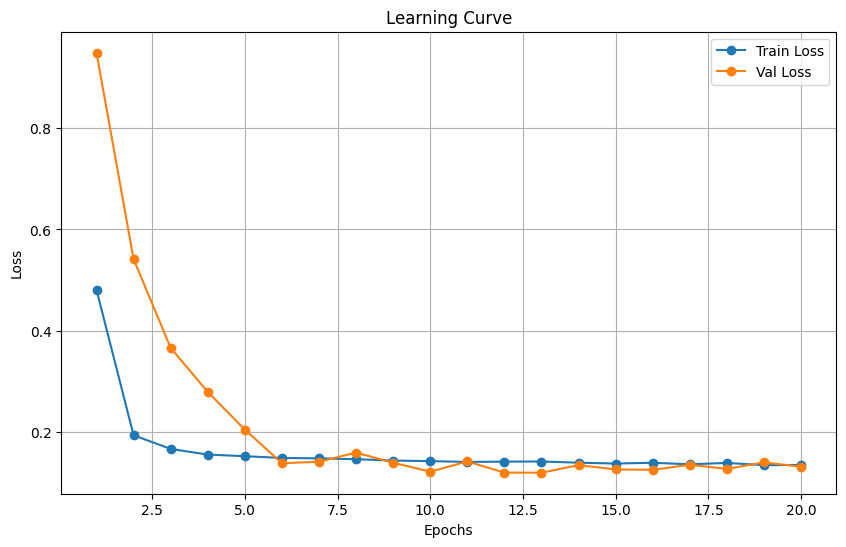

In [20]:
# Affichage des courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, epochs+1), val_losses, label='Val Loss', marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()
plt.grid()
plt.show()

## PS : Pour des soucis de temps, nous allons utiliser 20 époques au lieu de 50, nous pouvons constater qu'à partir de 10 époques environ, les pertes commencent déjà à stagner.

J'ai oublié la dernière question et vu que mes deux modèles s'appellent "model", je ne peux pas récupérer les poids à moins de reentrainer sans perceptrons. Pour visualiser les prédictions, il s'agirait de faire passer les attenuations dans le modèle et récuperer la sortie correspondant au taux de pluie associé. On compare ensuite par rapport aux valeurs réelles.

## Partie II

Dans la première partie, le modèle était générique: la specificité de la paire d'antenne n'était pas prise en compte. On se propose de le faire en combinant un réseau générique à un perceptron spécifique, de sorte que la sortie $Z$ s'exprime sous la forme: \
$$Z = F(X, k) = f^{\tiny{Perceptron}}_{\alpha_k}(f^{\tiny{UNet}}_{\theta}(X))$$ \
 où $f^{\tiny{UNet}}_{\theta}(.)$ représente la fonction *forward* d'un UNet et $f^{\tiny{Perceptron}}_{\alpha_k}(.)$, la fonction forward du perceptron associé à la paire d'antennes d'identifiant $k$. \

Il s'agit donc en premier lieu d'adjoindre au UNet de la partie I autant de perceptrons que le jeu d'entraînement compte de paires d'antennes, ce qui se fait grâce aux lignes suivantes:

In [ ]:
# Pour l'ajout de 1200 perceptrons à deux couches:
self.num_pairs = 1200
self.input_size_fc_layer = 5
self.hidden_size_fc_layer = 5
# Liste des premières couches
self.linears1 = nn.ModuleList([nn.Linear(self.input_size_fc_layer,
                                         self.hidden_size_fc_layer) for i in range(self.num_pairs)])
# Liste des secondes couches
self.linears2 = nn.ModuleList([nn.Linear(self.hidden_size_fc_layer,
                                         1) for i in range(self.num_pairs)])

**Consignes:** \
1) Définir une nouvelle classe de réseau en modifiant la classe UNet1D (dans utils_probleme1.py).
Ajouter ces perceptrons au réseau.

2) Fixer *self.n_classes* de façon à ce que la sortie du UNet soit compatible avec l'entrée du perceptron.

3) Modifications de la fonction forward:
- elle doit prendre comme arguments un batch d'entrées et un batch d'identifiants.

- après les étapes propres au UNet, elle doit appliquer le perceptron d'indice k à une série provenant de la paire n°k. La cellule de code suivante fournit un exemple dont on pourra directement s'inspirer.

4) Suivre les performances en généralisation sur les paires d'antennes du jeu d'entraînement et sur les deux cents paires de validation. Commenter.




In [30]:
class UNet1DWithPerceptrons(nn.Module):

    def apply_perceptron(self, UNet_output, ids):
      for i in range(ids.shape[0]):
          id = ids[i]
          # application de la première couche
          x = self.linears1[id](UNet_output[i].transpose(0,1).contiguous())
          x = self.relu(x)
          # application de la seconde couche
          x = self.linears2[id](x)
          # correction multiplicative de UNet_output
          UNet_output[i, 0:1, :] *= 1 + x.transpose(0, 1).contiguous()
      return UNet_output[:,0]

    def __init__(self, n_channels, size=64):
        super(UNet1DWithPerceptrons, self).__init__()
        # UNet components
        self.inc = inconv(n_channels, size)
        self.down1 = Down(size, 2*size)
        self.down2 = Down(2*size, 4*size)
        self.down3 = Down(4*size, 8*size)
        self.down4 = Down(8*size, 8*size)
        self.up1 = Up(8*size, 4*size)
        self.up2 = Up(4*size, 2*size)
        self.up3 = Up(2*size, size)
        self.up4 = Up(size, size)

        # Set n_classes to match perceptron input size
        self.n_classes = 5  # Correspond à input_size_fc_layer
        self.outc = outconv(size, self.n_classes)

        # Pour l'ajout de 1200 perceptrons à deux couches:
        self.num_pairs = 1200
        self.input_size_fc_layer = 5
        self.hidden_size_fc_layer = 5

        # Liste des premières couches
        self.linears1 = nn.ModuleList([nn.Linear(self.input_size_fc_layer,
                                                self.hidden_size_fc_layer) for i in range(self.num_pairs)])

        # Liste des secondes couches
        self.linears2 = nn.ModuleList([nn.Linear(self.hidden_size_fc_layer,
                                                1) for i in range(self.num_pairs)])

        self.relu = nn.ReLU()

    def forward(self, x, ids):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        del x4, x5
        x = self.up2(x, x3)
        del x3
        x = self.up3(x, x2)
        del x2
        x = self.up4(x, x1)
        del x1
        x = self.outc(x)
        return self.apply_perceptron(x, ids)

In [39]:
# Instanciation du modèle, de l'optimiseur et du critère
model = UNet1DWithPerceptrons(n_channels, size)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

# Déplacement du modèle sur GPU (si disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Création des dataloaders pour l'entraînement et la validation
train_loader = create_dataloader(duration, idx2distance_train, batch_size)
val_loader = create_dataloader(duration, idx2distance_val, batch_size)

# Initialisation des listes pour stocker les pertes
train_losses = []
val_losses = []

# Changement du nombre d'époques
epochs = 50

# Boucle sur les époques
for epoch in range(epochs):
    # Phase d'entraînement
    model.train()
    epoch_train_loss = 0.0
    for batch_idx, (ids, dists, rain_rates, attenuations) in enumerate(train_loader):
        # Déplacement des données sur GPU
        attenuations = attenuations.to(device)
        rain_rates = rain_rates.to(device)
        ids = ids.to(device)  # Déplacer les IDs sur GPU

        # Forward pass
        outputs = model(attenuations.unsqueeze(1), ids) # Passage des IDs au modèle

        # Calcul de la perte
        loss = criterion(outputs[:, 120:-120], rain_rates[:, 120:-120])

        # Backpropagation et optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Phase de validation
    model.eval()
    with torch.no_grad():
        epoch_val_loss = 0.0
        for batch_idx, (ids, dists, rain_rates, attenuations) in enumerate(val_loader):
            # Déplacement des données sur GPU
            attenuations = attenuations.to(device)
            rain_rates = rain_rates.to(device)
            ids = ids.to(device) # Déplacer les IDs sur GPU

            # Forward pass
            outputs = model(attenuations.unsqueeze(1), ids) # Passage des IDs au modèle

            # Calcul de la perte
            loss = criterion(outputs[:, 120:-120], rain_rates[:, 120:-120])
            epoch_val_loss += loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

Epoch [1/50], Train Loss: 0.3147, Val Loss: 0.2931
Epoch [2/50], Train Loss: 0.2280, Val Loss: 0.2339
Epoch [3/50], Train Loss: 0.2203, Val Loss: 0.1970
Epoch [4/50], Train Loss: 0.2219, Val Loss: 0.1941
Epoch [5/50], Train Loss: 0.2181, Val Loss: 0.1878
Epoch [6/50], Train Loss: 0.2140, Val Loss: 0.2175
Epoch [7/50], Train Loss: 0.2089, Val Loss: 0.1910
Epoch [8/50], Train Loss: 0.2053, Val Loss: 0.1970
Epoch [9/50], Train Loss: 0.2051, Val Loss: 0.2126
Epoch [10/50], Train Loss: 0.2066, Val Loss: 0.1919
Epoch [11/50], Train Loss: 0.2026, Val Loss: 0.1909
Epoch [12/50], Train Loss: 0.1968, Val Loss: 0.1912
Epoch [13/50], Train Loss: 0.1994, Val Loss: 0.2052
Epoch [14/50], Train Loss: 0.1995, Val Loss: 0.2836
Epoch [15/50], Train Loss: 0.1965, Val Loss: 0.1865
Epoch [16/50], Train Loss: 0.1923, Val Loss: 0.1777
Epoch [17/50], Train Loss: 0.1923, Val Loss: 0.1984
Epoch [18/50], Train Loss: 0.1906, Val Loss: 0.1810
Epoch [19/50], Train Loss: 0.1867, Val Loss: 0.1817
Epoch [20/50], Train 

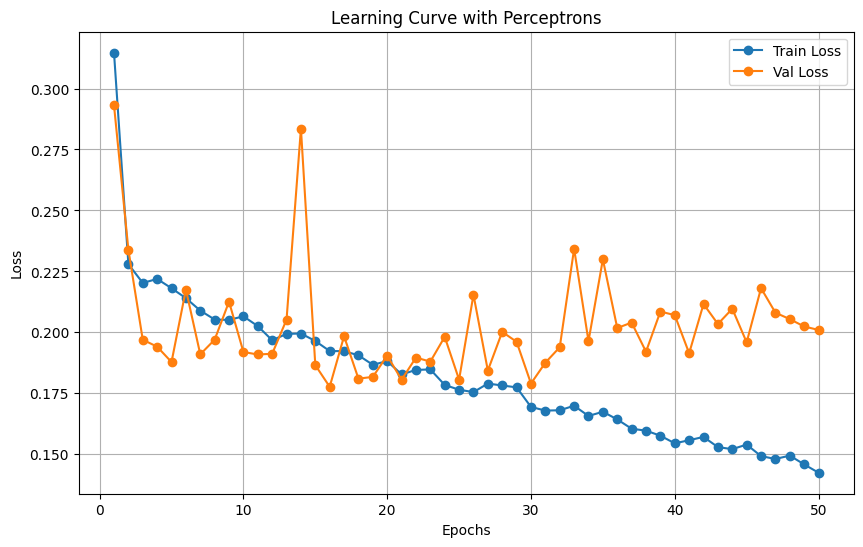

In [40]:
# Affichage des courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, epochs+1), val_losses, label='Val Loss', marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve with Perceptrons")
plt.legend()
plt.grid()
plt.show()

La Partie II introduit des perceptrons spécifiques à chaque paire d'antennes du jeu d'entraînement. Cela entraîne une baisse de performance sur les paires d'antennes du jeu de validation (inconnues pendant l'entraînement). L'ajout des perceptrons spécifiques  améliore les performances sur les paires d'antennes connues, mais dégrade lors de la validation les performances sur les paires inconnues. La perte de validation élevée suggère un overfitting sur les paires d'antennes utiliser lors de l'entraînement.

## Partie III

La solution proposée dans la partie II a un défaut: les performances chutent sur les paires d'antennes qui n'ont pas été rencontrées pendant l'entraînement. Pour le corriger, on se propose de suivre la méthode suivante:
- ajouter un perceptron "générique" de même architecture que les perceptrons spécifiques.
- entraîner le réseau de la partie II en remplaçant une fois sur quatre l'identifiant de la paire d'antennes par l'indice du perceptron générique.
- après cinquante époques, geler les poids de la partie générique et prolonger l'apprentissage des perceptrons spécifiques sur une vingtaine d'époque.

**Consignes:** \

1) Mettre en oeuvre cette méthode

2) Conclure sur son efficacité